In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision.io import read_image
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from common.utils import crop, weights_init, save_config, save_loss, get_FID
from common.dataset import USImagesDataset
import yaml
import random
import os
from torch.nn.utils import spectral_norm
from datetime import datetime
from unet.model import UNet

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

%matplotlib inline

def show_tensor_images(image_tensor, num_images=5, size=(1, 150, 150)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
#     plt.savefig(f"gan-results/gan_epoch-{epoch}-examples.pdf", bbox_inches='tight')
    plt.show()

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=64, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential( # 200
            self.make_gen_block(z_dim, hidden_dim * 16),  # 4x4,
            self.make_gen_block(hidden_dim * 16, hidden_dim * 8, stride=2),  # 3*2+4=10,
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4), # 9*3+4=31,
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=5, stride=2), # 30*2+5=65
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=5, stride=3), # 64*3+5=197,
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, stride=1, final_layer=True)  #196+4 = 200x200
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=4, stride=3, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, bias=False),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, bias=False),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = self.gen(noise)
        return x


class Critic(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=64, spectral_norm=True):
        super(Critic, self).__init__()
        self.spectral_norm = spectral_norm
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, hidden_dim * 4),
            self.make_crit_block(hidden_dim * 4, 1, final_layer=True),
        )
        self.sigmoid = nn.Sigmoid()

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
               spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride, bias=False))
                if self.spectral_norm 
                else nn.Conv2d(input_channels, output_channels, kernel_size, stride, bias=False),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride, bias=False))
                if self.spectral_norm 
                else nn.Conv2d(input_channels, output_channels, kernel_size, stride, bias=False),
            )

    def forward(self, image):
        crit_pred = self.crit(image)
        features = crit_pred.view(len(crit_pred), -1)
        return crit_pred, features

In [3]:
def get_gradient(crit, real, fake, epsilon):
    mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_scores, _ = crit(mixed_images)
    
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, 1, 1, device=device)

In [4]:
config = {
    "image_path": "/home/student/synthetic-us-images/camus-images/image",
    "device": "cuda",
    "beta_1": 0.5,
    "beta_2": 0.999,
    "crit_repeats": 3,
    "gen_repeats": 1,
    "batch_size": 4,
    "disc_lr": 4e-4,
    "gen_lr": 1e-4,
    "n_epochs": 200,
    "c_lambda": 10,
    "epoch_log_step": 5,
    "z_dim": 32,
    "initial_shape": 200,  
    "spectral_norm": True
}


In [5]:

dt = datetime.today().strftime("%d-%m-%Y-%H:%M")
result_folder = f"gan-wgan-{dt}"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

save_config(f"{result_folder}/config.json", config)

In [6]:
def save_model(epoch, gen, disc, opt_g, opt_d):
    torch.save({
        "epoch": epoch,
        "opt_g": opt_g.state_dict(),
        "gan": gen.state_dict(),
        "opt_d": opt_d.state_dict(),
        "disc": disc.state_dict()
    }, f"{result_folder}/{epoch}.pth")

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
    transforms.Resize((config["initial_shape"], config["initial_shape"]))
    
])
dataset = USImagesDataset(config["image_path"], image_transform=transform)

dataloader = DataLoader(dataset, batch_size=config["batch_size"], num_workers=0)


[EPOCH 1/200 | Loss_C: 8.0980 Loss_G: -0.7108


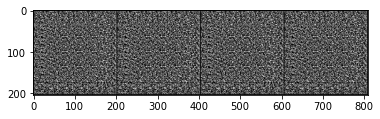

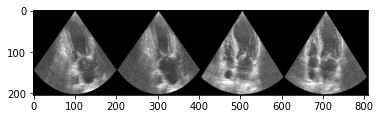

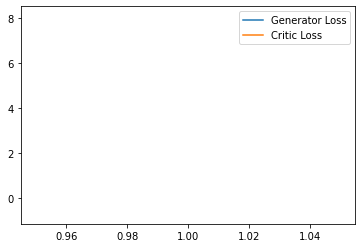


[EPOCH 2/200 | Loss_C: 0.3748 Loss_G: -0.9727


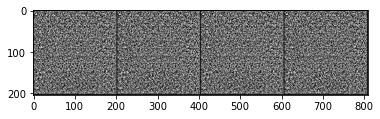

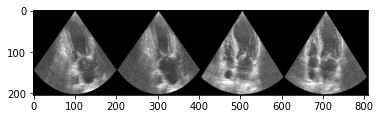

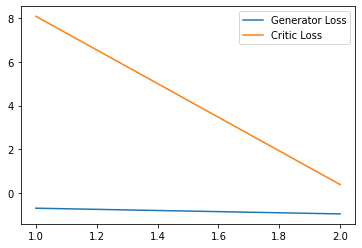


[EPOCH 3/200 | Loss_C: -0.0866 Loss_G: -1.3784


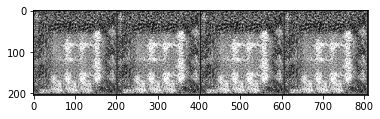

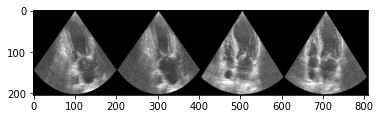

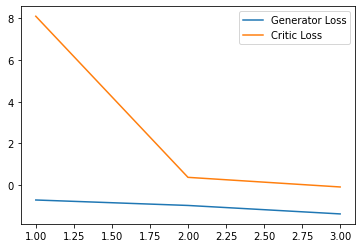


[EPOCH 4/200 | Loss_C: 0.0069 Loss_G: -1.7315


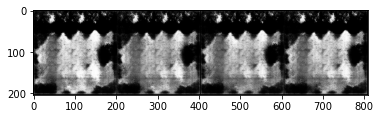

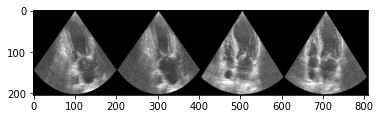

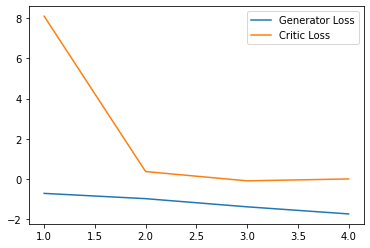


[EPOCH 5/200 | Loss_C: 0.1113 Loss_G: -0.8077


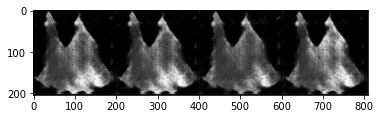

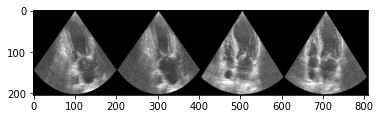

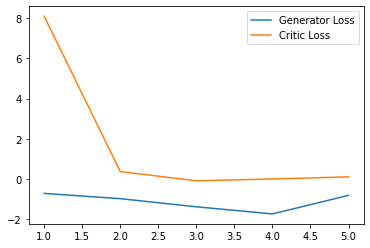


[EPOCH 6/200 | Loss_C: 0.1099 Loss_G: 0.2234


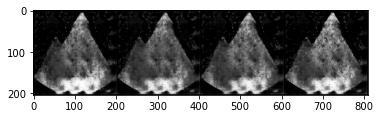

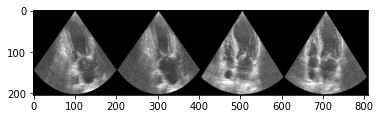

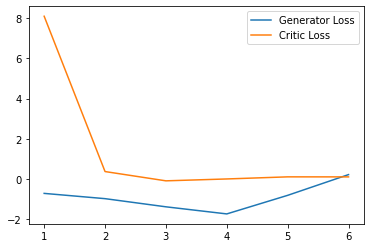


[EPOCH 7/200 | Loss_C: 0.1273 Loss_G: 0.6589


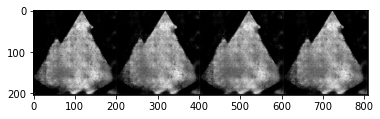

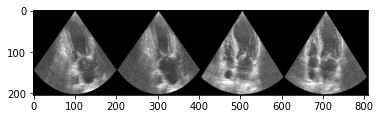

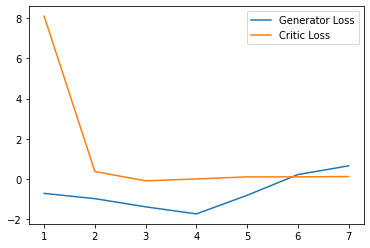


[EPOCH 8/200 | Loss_C: 0.1223 Loss_G: 0.9694


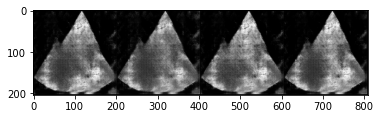

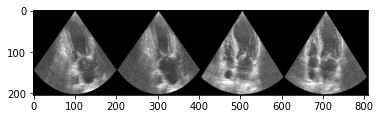

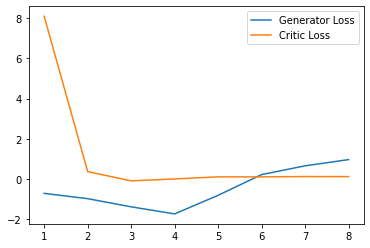


[EPOCH 9/200 | Loss_C: 0.1118 Loss_G: 1.5063


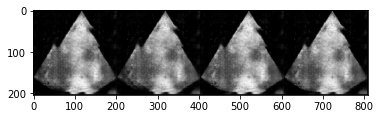

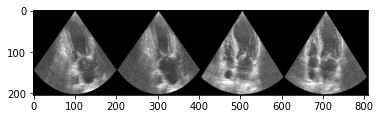

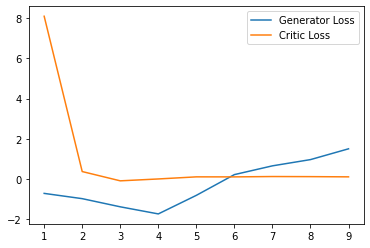


[EPOCH 10/200 | Loss_C: 0.1429 Loss_G: 1.7315


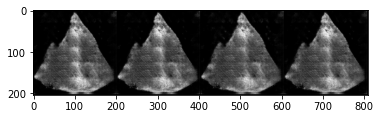

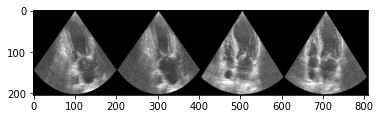

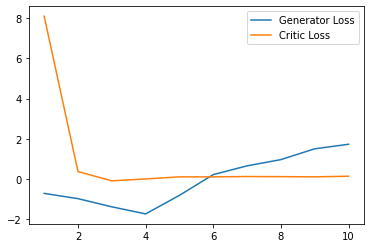


[EPOCH 11/200 | Loss_C: 0.1200 Loss_G: 2.3145


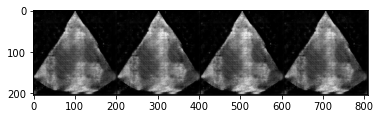

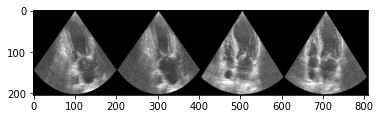

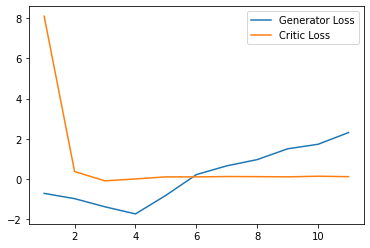


[EPOCH 12/200 | Loss_C: 0.0996 Loss_G: 2.2231


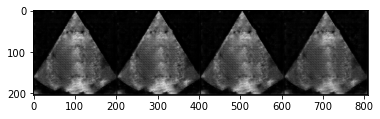

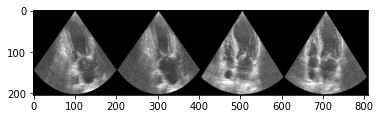

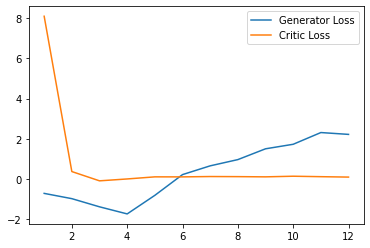


[EPOCH 13/200 | Loss_C: 0.1417 Loss_G: 1.9821


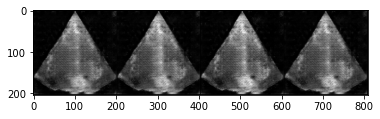

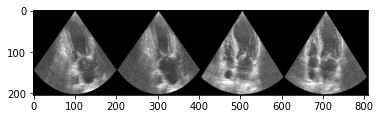

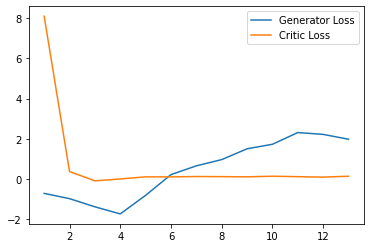


[EPOCH 14/200 | Loss_C: 0.1096 Loss_G: 2.2476


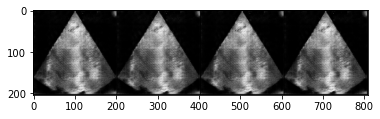

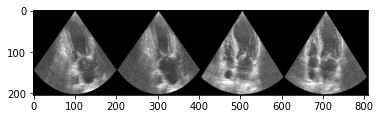

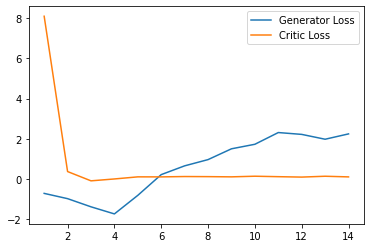


[EPOCH 15/200 | Loss_C: 0.1055 Loss_G: 2.0178


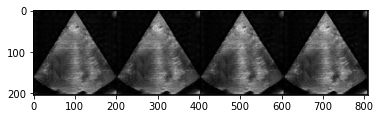

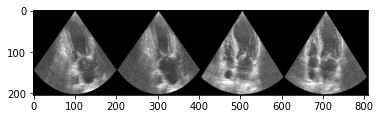

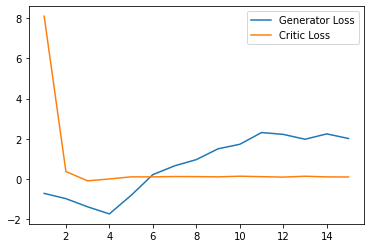


[EPOCH 16/200 | Loss_C: 0.1041 Loss_G: 1.8990


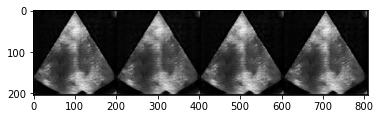

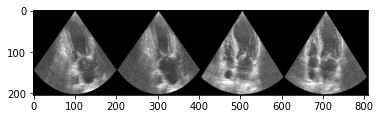

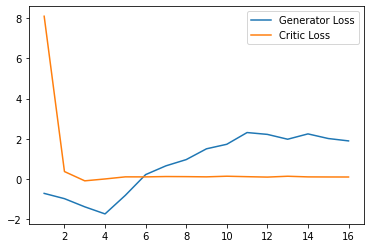


[EPOCH 17/200 | Loss_C: 0.0956 Loss_G: 2.0383


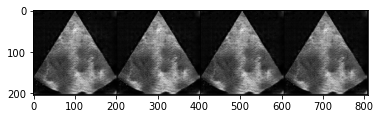

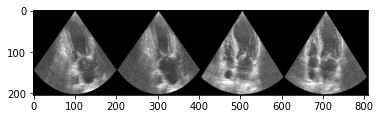

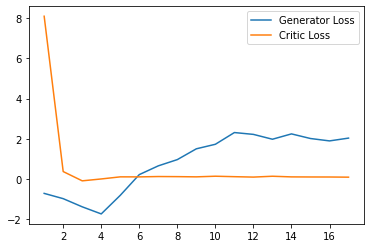


[EPOCH 18/200 | Loss_C: 0.0873 Loss_G: 1.9189


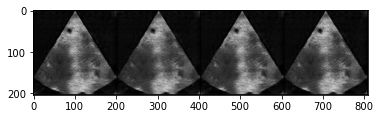

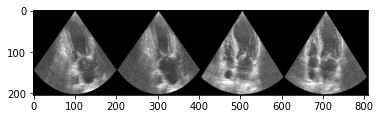

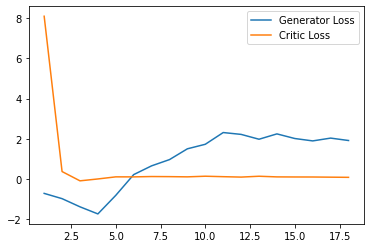


[EPOCH 19/200 | Loss_C: 0.0890 Loss_G: 1.8326


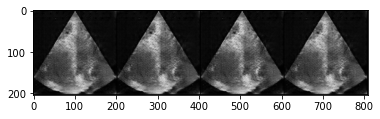

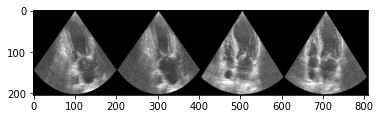

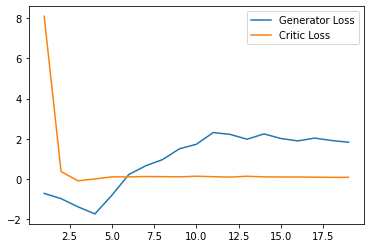


[EPOCH 20/200 | Loss_C: 0.0794 Loss_G: 1.8236


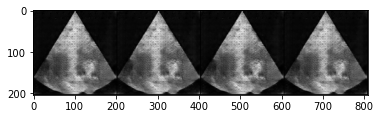

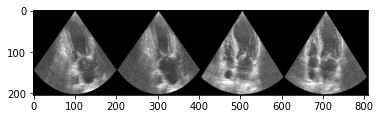

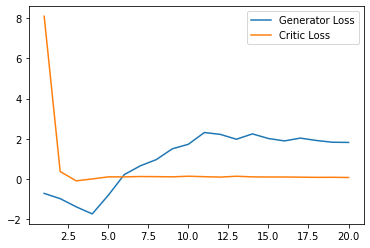


[EPOCH 21/200 | Loss_C: 0.0846 Loss_G: 1.6267


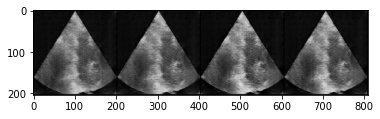

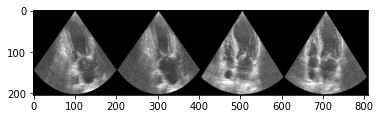

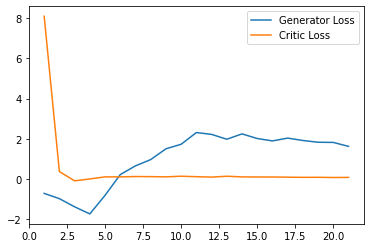


[EPOCH 22/200 | Loss_C: 0.0747 Loss_G: 1.5945


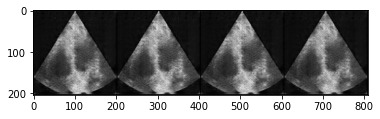

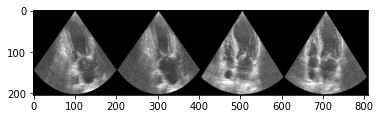

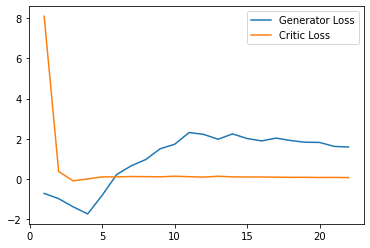


[EPOCH 23/200 | Loss_C: 0.0791 Loss_G: 1.4333


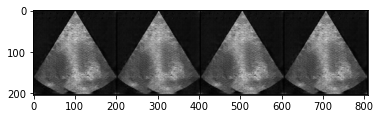

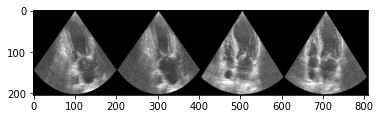

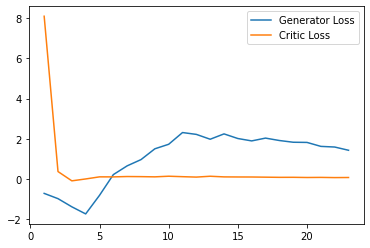


[EPOCH 24/200 | Loss_C: 0.0741 Loss_G: 1.2953


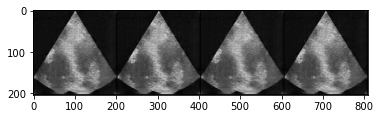

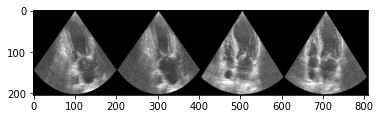

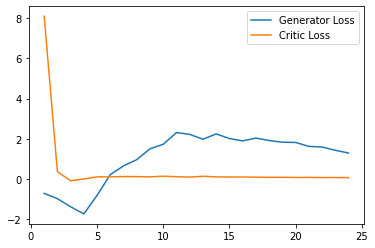


[EPOCH 25/200 | Loss_C: 0.0740 Loss_G: 1.0496


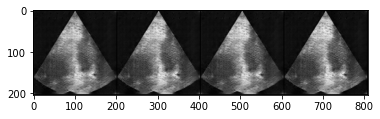

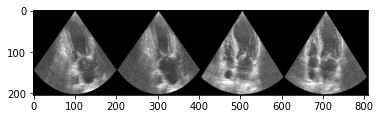

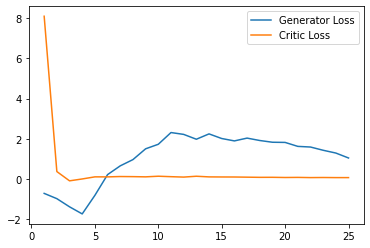


[EPOCH 26/200 | Loss_C: 0.0674 Loss_G: 1.0208


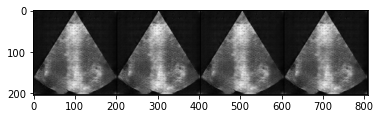

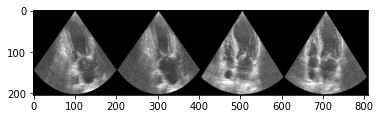

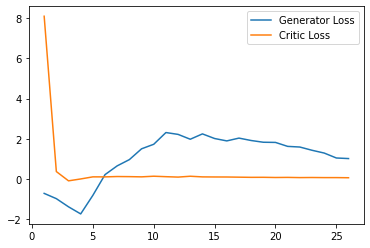


[EPOCH 27/200 | Loss_C: 0.0625 Loss_G: 0.9444


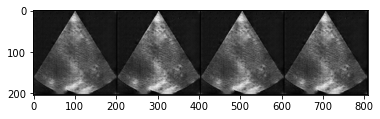

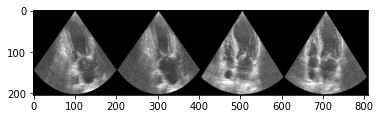

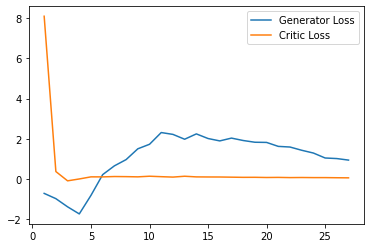


[EPOCH 28/200 | Loss_C: 0.0624 Loss_G: 0.8368


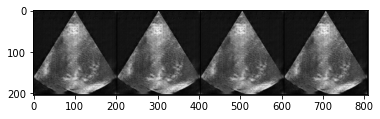

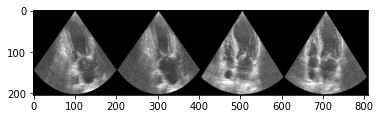

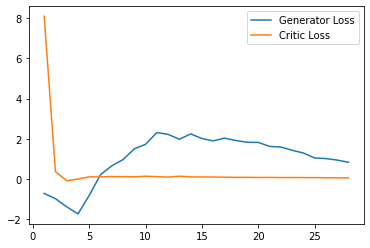


[EPOCH 29/200 | Loss_C: 0.0608 Loss_G: 0.8319


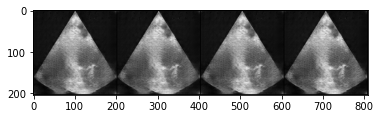

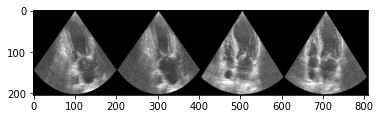

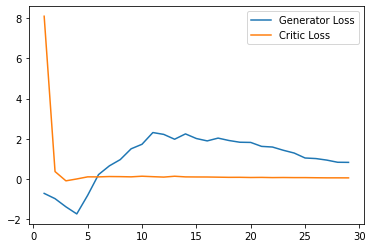


[EPOCH 30/200 | Loss_C: 0.0660 Loss_G: 0.7693


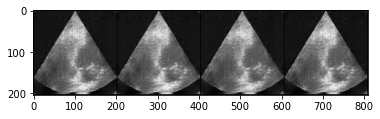

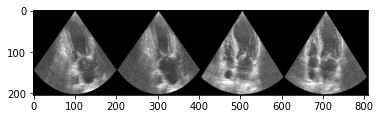

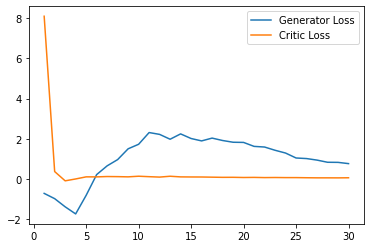


[EPOCH 31/200 | Loss_C: 0.0630 Loss_G: 0.7865


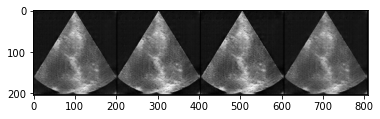

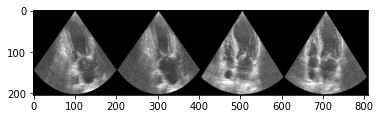

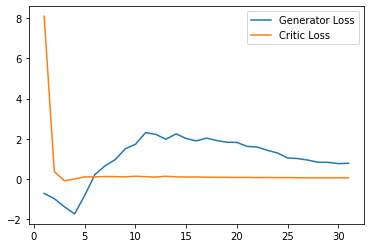


[EPOCH 32/200 | Loss_C: 0.0518 Loss_G: 0.7771


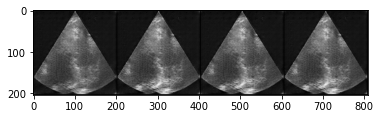

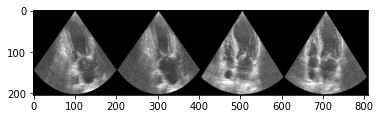

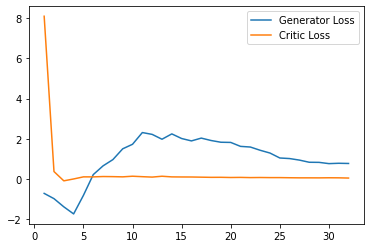


[EPOCH 33/200 | Loss_C: 0.0570 Loss_G: 0.7590


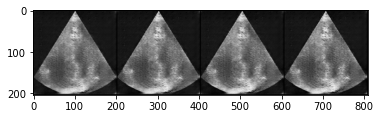

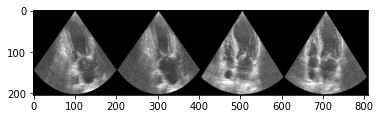

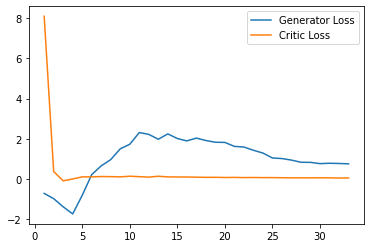


[EPOCH 34/200 | Loss_C: 0.0528 Loss_G: 0.8108


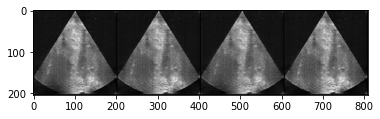

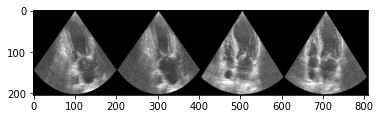

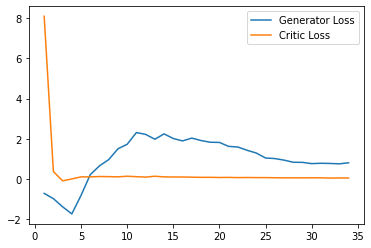


[EPOCH 35/200 | Loss_C: 0.0468 Loss_G: 0.8519


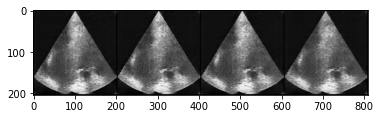

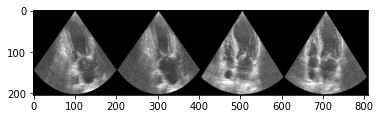

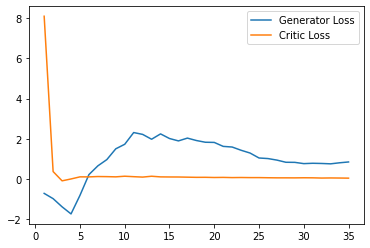


[EPOCH 36/200 | Loss_C: 0.0519 Loss_G: 0.7896


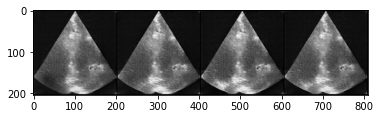

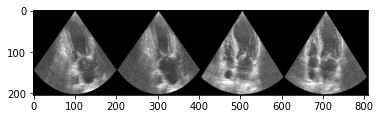

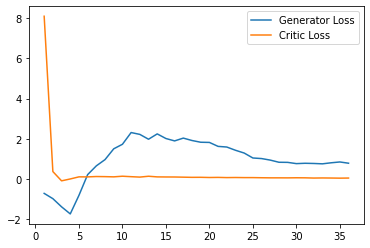


[EPOCH 37/200 | Loss_C: 0.0430 Loss_G: 0.8331


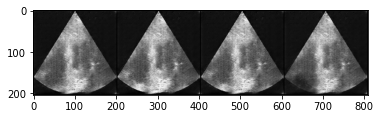

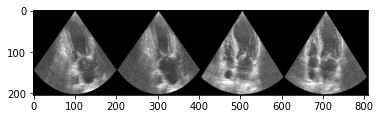

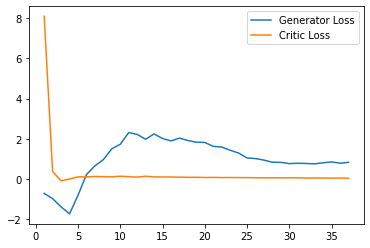


[EPOCH 38/200 | Loss_C: 0.0488 Loss_G: 0.8446


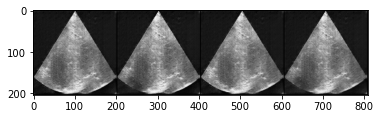

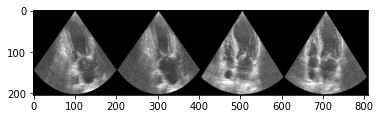

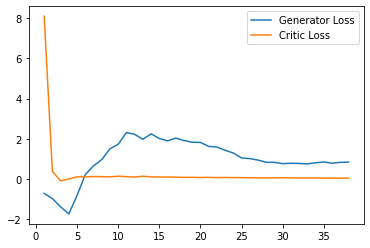


[EPOCH 39/200 | Loss_C: 0.0497 Loss_G: 0.8084


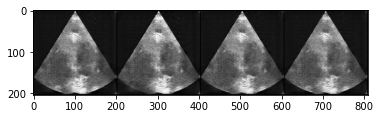

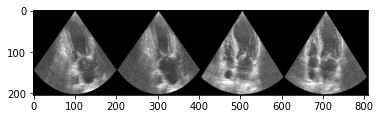

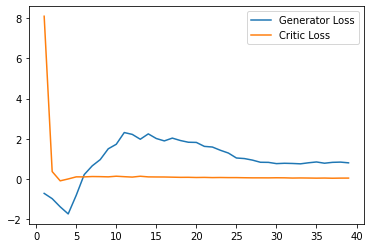


[EPOCH 40/200 | Loss_C: 0.0444 Loss_G: 0.7487


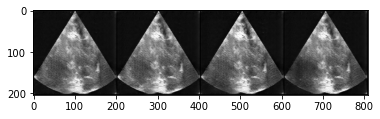

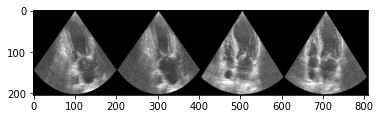

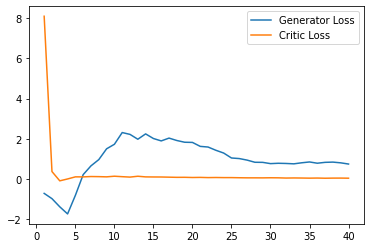


[EPOCH 41/200 | Loss_C: 0.0443 Loss_G: 0.8069


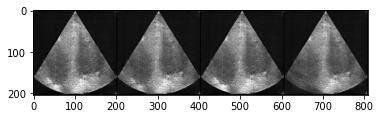

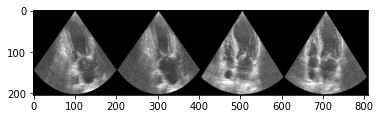

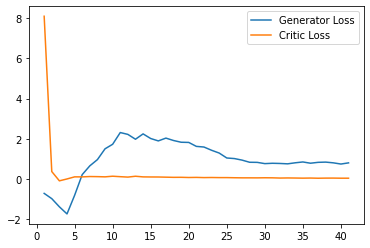


[EPOCH 42/200 | Loss_C: 0.0413 Loss_G: 0.8404


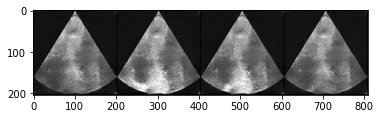

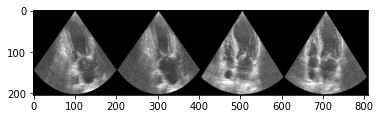

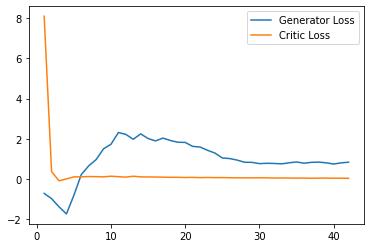


[EPOCH 43/200 | Loss_C: 0.0432 Loss_G: 0.8422


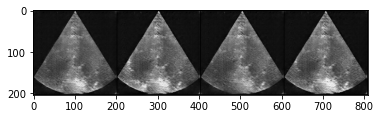

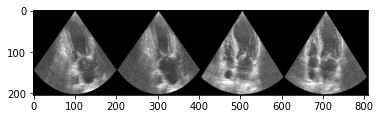

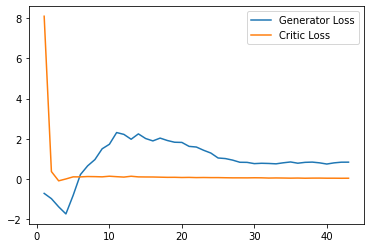


[EPOCH 44/200 | Loss_C: 0.0407 Loss_G: 0.8140


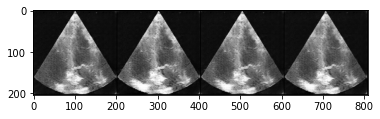

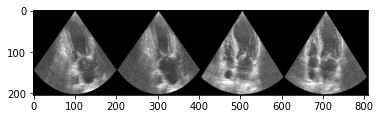

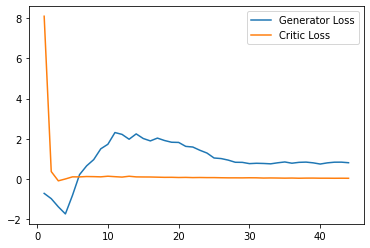


[EPOCH 45/200 | Loss_C: 0.0376 Loss_G: 0.7824


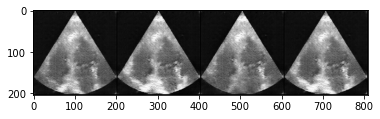

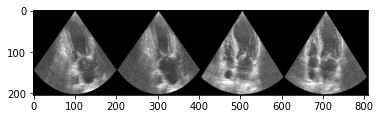

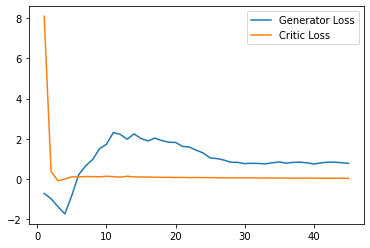


[EPOCH 46/200 | Loss_C: 0.0373 Loss_G: 0.8284


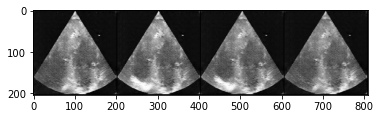

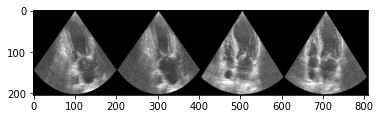

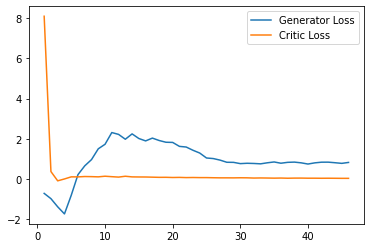


[EPOCH 47/200 | Loss_C: 0.0407 Loss_G: 0.8478


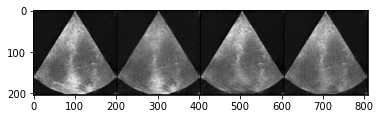

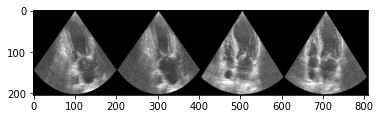

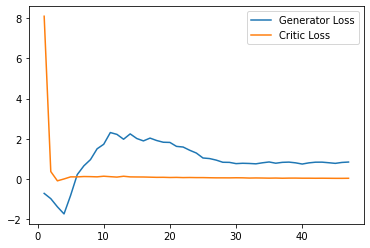


[EPOCH 48/200 | Loss_C: 0.0369 Loss_G: 0.7559


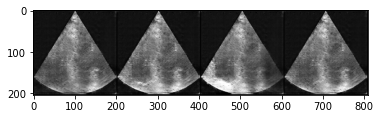

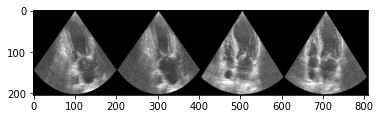

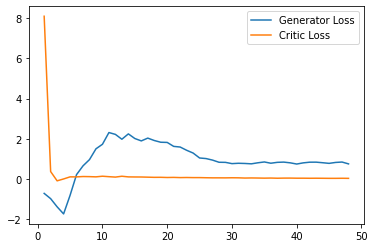


[EPOCH 49/200 | Loss_C: 0.0405 Loss_G: 0.9317


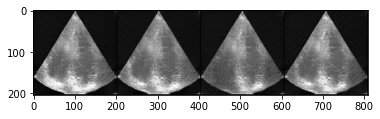

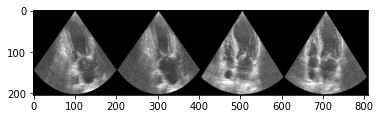

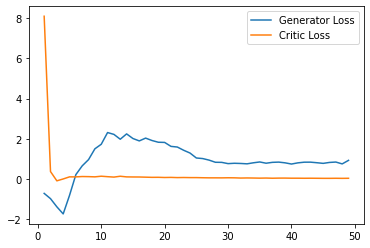


[EPOCH 50/200 | Loss_C: 0.0371 Loss_G: 0.8360


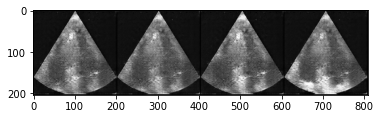

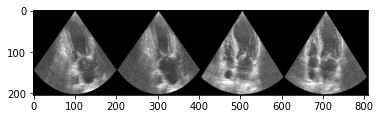

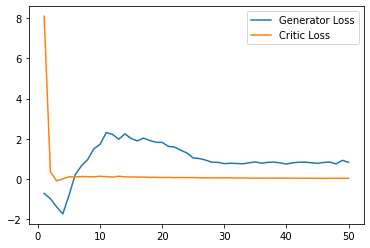


[EPOCH 51/200 | Loss_C: 0.0426 Loss_G: 0.8933


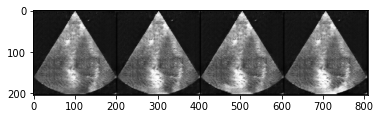

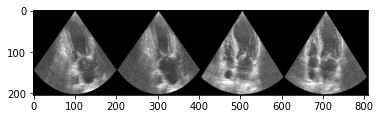

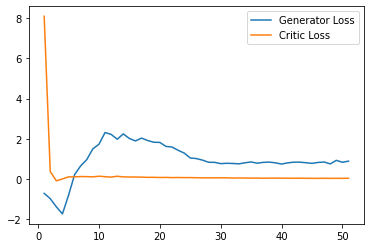


[EPOCH 52/200 | Loss_C: 0.0513 Loss_G: 0.9862


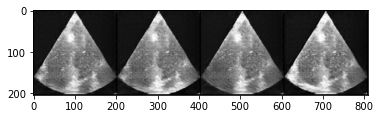

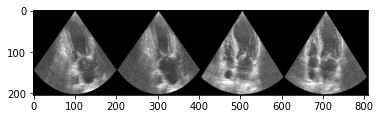

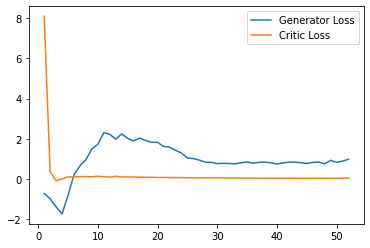


[EPOCH 53/200 | Loss_C: 0.0414 Loss_G: 0.9984


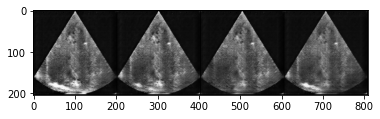

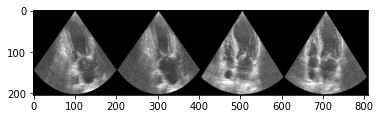

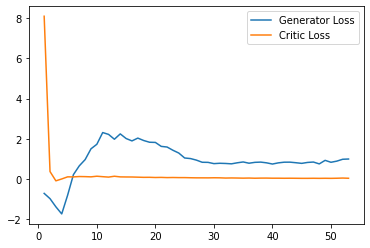


[EPOCH 54/200 | Loss_C: 0.0429 Loss_G: 0.9836


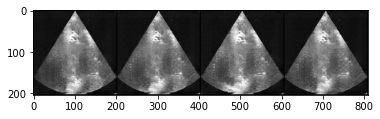

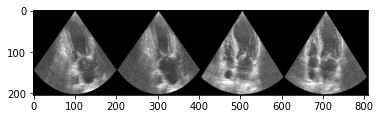

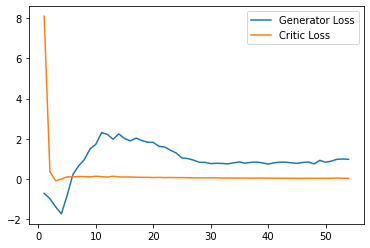


[EPOCH 55/200 | Loss_C: 0.0411 Loss_G: 0.9115


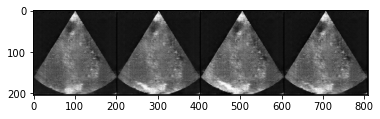

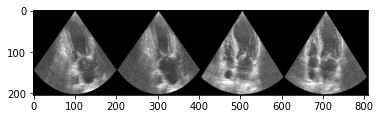

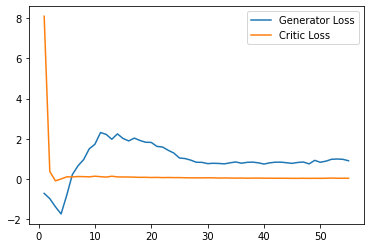


[EPOCH 56/200 | Loss_C: 0.0382 Loss_G: 0.9762


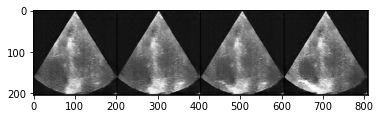

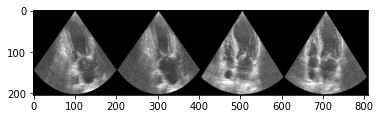

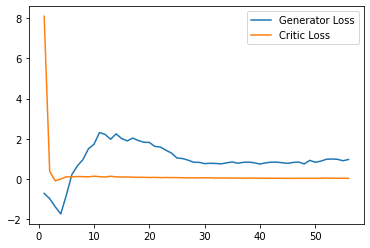


[EPOCH 57/200 | Loss_C: 0.0406 Loss_G: 1.0018


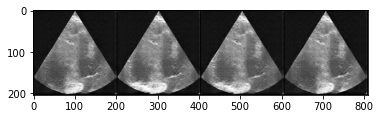

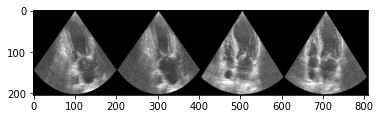

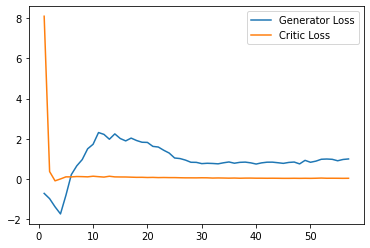


[EPOCH 58/200 | Loss_C: 0.0347 Loss_G: 1.0553


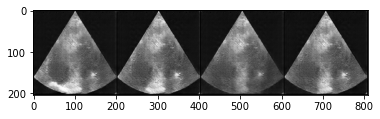

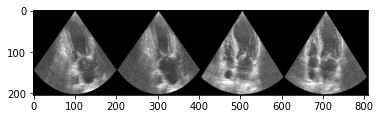

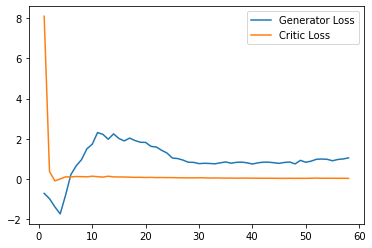


[EPOCH 59/200 | Loss_C: 0.0316 Loss_G: 1.0099


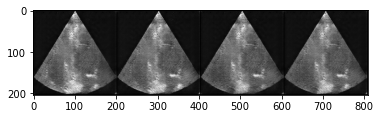

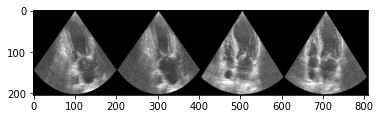

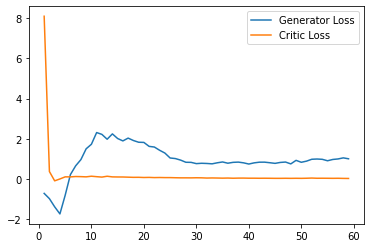


[EPOCH 60/200 | Loss_C: 0.0351 Loss_G: 1.0984


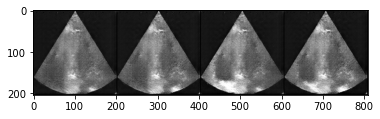

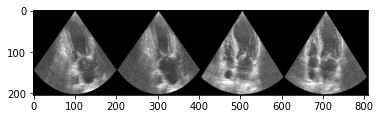

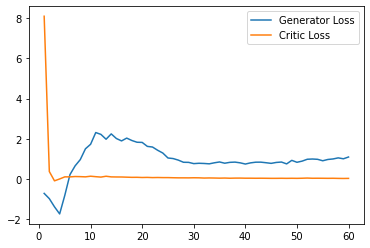


[EPOCH 61/200 | Loss_C: 0.0350 Loss_G: 1.1613


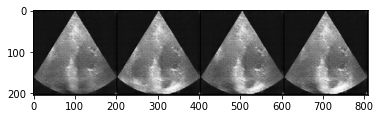

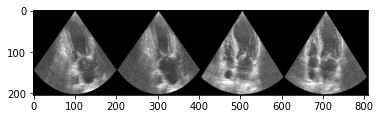

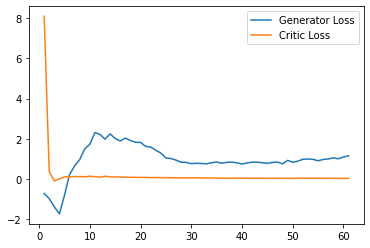

In [ ]:
gen = Generator(z_dim=config["z_dim"]).to(config["device"])
weights_init(gen)
gen_opt = torch.optim.Adam(gen.parameters(), lr=config["gen_lr"], betas=(config["beta_1"], config["beta_2"]))

crit = Critic(spectral_norm=config["spectral_norm"]).to(config["device"])
weights_init(crit)
crit_opt = torch.optim.Adam(crit.parameters(), lr=config["disc_lr"], betas=(config["beta_1"], config["beta_2"]))


gen_losses = []
crit_losses = []
for epoch in range(1, config["n_epochs"] + 1):
    epoch_gen_loss = 0
    epoch_crit_loss = 0

    for real in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(config["device"])

        ## Update discriminator ###
        running_crit_loss = 0
        for _ in range(config["crit_repeats"]):
            crit_opt.zero_grad()
            fake = gen(get_noise(cur_batch_size, config["z_dim"], device=config["device"]))
            crit_fake_pred, _ = crit(fake.detach())
            crit_real_pred, _ = crit(real)
            
            epsilon = torch.rand(cur_batch_size, 1, 1, 1, device=config["device"], requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, config["c_lambda"])
            crit_loss.backward(retain_graph=True)
            
            crit_opt.step()
            
            running_crit_loss += crit_loss.item() / config["crit_repeats"]        

        epoch_crit_loss += running_crit_loss / len(dataloader)

        ### Update generator ###
        running_gen_loss = 0
        for _ in range(config["gen_repeats"]):
            gen_opt.zero_grad()
            fake_2 = gen(get_noise(cur_batch_size, config["z_dim"], device=config["device"]))
            
            crit_fake_pred, _ = crit(fake_2)

            gen_loss = get_gen_loss(crit_fake_pred)
            gen_loss.backward()
            gen_opt.step()
            
            running_gen_loss += gen_loss.item() / config["gen_repeats"]

        epoch_gen_loss += running_gen_loss / len(dataloader)
    
    crit_losses += [epoch_crit_loss]
    gen_losses += [epoch_gen_loss]
    print(f"[EPOCH {epoch}/{config['n_epochs']} | Loss_C: {epoch_crit_loss:.4f} Loss_G: {epoch_gen_loss:.4f}")
    show_tensor_images((fake_2 + 1) / 2, size=fake_2.shape[1:])
    show_tensor_images((real + 1) / 2, size=real.shape[1:])
    plt.plot(range(1, len(gen_losses) + 1), gen_losses, label="Generator Loss")
    plt.plot(range(1, len(crit_losses) + 1), crit_losses, label="Critic Loss")
    plt.legend(loc="best")
    plt.show()
    
    if epoch % config["epoch_log_step"] == 0:
        save_model(epoch, gen, crit, gen_opt, crit_opt)

save_loss(f"{result_folder}/critic_loss.csv", crit_loss)      
save_loss(f"{result_folder}/gen_loss.csv", gen_loss)

In [ ]:
gen_losses = np.loadtxt("gan-wgan-01-12-2021-18:28/.csv", dtype=int)

plt.plot(range(1, len(gen_losses) + 1), gen_losses, label="Generator Loss")
plt.plot(range(1, len(disc_losses) + 1), disc_losses, label="Discriminator Loss")
plt.legend(loc="best")
plt.savefig(f"lsloss_loss.pdf", bbox_inches='tight')
plt.show()



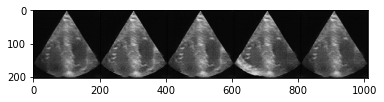

In [25]:
gen = Generator(z_dim=config["z_dim"]).to(config["device"])
gen.load_state_dict(torch.load("./gan-wgan-01-12-2021-18:28/120.pth")["gan"])
gen.eval()
with torch.no_grad():
    fakes_images = gen(get_noise(5, config["z_dim"], device=config["device"]))

    images = ((fakes_images + 1) / 2).detach().cpu()
#     real_images = (torch.stack(random.choices(dataset, k=5)) + 1) / 2
#     images = torch.cat((fakes_images, real_images),)
    
    image_unflat = images.cpu().view(-1, *images.shape[1:])
    image_grid = make_grid(image_unflat[:10], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

#     plt.savefig(f"wgan-test.jpg", bbox_inches='tight')


In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
    transforms.Resize((200, 200))
    
])
val_dataset = USImagesDataset("camus-images/image", image_transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=10, num_workers=0)

In [32]:
device = "cuda"
test_gen = Generator(z_dim=config["z_dim"]).to(config["device"]).to(device)
test_gen.load_state_dict(torch.load("./gan-wgan-01-12-2021-18:28/200.pth")["gan"])
test_gen.eval()

unet_model = UNet(hidden_channels=16).to(config["device"])
unet_model.load_state_dict(torch.load("./unet-results/u-net_79.pth")["unet"])
unet_model.eval()

fake_features_list = []
real_features_list = []
with torch.no_grad():
    for real_example in tqdm(val_dataloader):
        real_samples = real_example.to(device)
        pred, real_features = unet_model(real_samples)
        
        real_features = torch.flatten(real_features.detach().to('cpu'), start_dim=1)
        real_features_list.append(real_features)

        fake_samples = get_noise(len(real_example), z_dim).to(device)
        fake_samples = test_gen(fake_samples)
        _, fake_features = unet_model(fake_samples.to(device))
        fake_features = torch.flatten(fake_features.detach().to('cpu'), start_dim=1)
        fake_features_list.append(fake_features)
    
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)
fid = get_FID(fake_features_all, real_features_all)

In [33]:
fid.item()

440.0115966796875